# LSTM

## Caricamento del dataframe

In [1]:
import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn as nn

import numpy as np
import pandas as pd
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score

from torch.utils.tensorboard import SummaryWriter

from scipy.stats import mode

import os
import shutil
import glob

main_folder = "../data"

folder = "./runs/LSTM_1"

try:
    shutil.rmtree(folder, ignore_errors=True)
except:
    pass

try:
    os.mkdir(folder)
except:
    pass

writer = SummaryWriter(folder)

## Train - Validation - Test

In [2]:
class2idx = {
    "No_action": 0,
    "Prendi": 1,
    "Rilascia": 2,
    "Premi": 3
}

idx2class = {v: k for k, v in class2idx.items()}

In [3]:
def create_set(folder_set):
    csv:list = []
    for file in glob.glob(folder_set + "/*.csv"):
        csv.append(file)
    data = []
    target = []
    for fcsv in csv:
        data_video = pd.read_csv(fcsv, usecols = [i for i in range(156)]).to_numpy()
        target_video = pd.read_csv(fcsv, usecols = ["TARGET"])
        target_video["TARGET"].replace(class2idx, inplace=True)
        data.append(data_video)
        target.append(target_video.to_numpy())
    return (np.array(data, dtype=object), np.array(target, dtype=object))

In [4]:
folder_set = [[main_folder + "/train_set", main_folder + "/train.csv"], [main_folder + "/test_set", main_folder + "/test.csv"], [main_folder + "/val_set", main_folder + "/val.csv"]]

train_array, train_label_array = create_set(folder_set[0][0])
test_array, test_label_array = create_set(folder_set[1][0])
val_array, val_label_array = create_set(folder_set[2][0])

## Parametri del modello

In [5]:
class ClassifierDataset(Dataset):
    
    def __init__(self, array, label, index_data, window):
        self.index_data = index_data
        self.array = array
        self.label = label
        self.window = window
        
    def __getitem__(self, index):
        file_index = self.index_data[index][0].tolist()
        i = self.index_data[index][1]
        j = self.index_data[index][2]
        if i == j:
            x_data = [self.array[file_index][i]] * self.window
            y_data = self.label[file_index][i]
            X = torch.from_numpy(np.array(x_data).astype(float)).float()
            Y = torch.from_numpy(np.array([y_data]).astype(int)).long()
            return X, Y
        elif j-i < self.window-1:
            x_data = [self.array[file_index][i]] * (self.window-j)
            x_data.extend(self.array[file_index][(i+1):(j+1)])
            x_data = np.array(x_data).astype(float)
        else:
            x_data = self.array[file_index][i:(j+1)]
            k = j-1
            while len(x_data) > self.window:
                x_data = self.array[file_index][i:(k+1)]
                k -= 1
        X = torch.from_numpy(x_data).float()
        y_data = self.label[file_index][i:(j+1)]
        y_mode = mode(y_data)[0][0]
        Y = torch.from_numpy(np.array([y_mode])).long()
        return X, Y
        
    def __len__ (self):
        return len(self.index_data)

In [6]:
def create_dataset(array_data, label_data, window):
    X = []
    files_num = len(array_data)
    for index, array, label in zip(range(files_num), array_data, label_data):
        l = array.shape[0]
        i = 0
        while l - i >= window:
            j = i + window
            index_window = np.array([index, i, j]).astype(int)
            X.append(index_window)
            i += window
        if i < l:
            w = l - i
            i = i - w - window
            j = i + window
            index_window = np.array([index, i, j]).astype(int)
            X.append(index_window)
    X_data = torch.from_numpy(np.array(X).astype(int))
    return ClassifierDataset(array_data, label_data, X_data, window)

In [7]:
def create_dataset2(array_data, label_data, window):
    X = []
    files_num = len(array_data)
    for index, array, label in zip(range(files_num), array_data, label_data):
        l = array.shape[0]
        i = -1
        w = [0] * window
        while i < l:
            i += 1 
            w.pop(0)
            w.append(i)
            index_window = np.array([index, w[0], i]).astype(int)
            X.append(index_window)
    X_data = torch.from_numpy(np.array(X).astype(int))
    return ClassifierDataset(array_data, label_data, X_data, window)

In [8]:
EPOCHS = 200
window = 182
BATCH_SIZE = 64
LEARNING_RATE = 0.005217779658903428
NUM_LAYER = 1
NUM_HIDDEN = 32
NUM_FEATURES = 156
NUM_CLASSES = 4
index_name = 2
esperimento = 1
model_name = "../data/modelli_senza_overlap/000" + str(index_name) + "_mymodel.pt"

In [9]:
train_dataset = create_dataset(train_array, train_label_array, window)
test_dataset = create_dataset2(test_array, test_label_array, window)
val_dataset = create_dataset2(val_array, val_label_array, window)

In [10]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

## Rete Neurale LSTM

In [11]:
class LSTM(nn.Module):
    def __init__(self, input_size, window, output_size, hidden_layer_size, num_layers):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_layer_size
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers)
        self.regressor = nn.Linear(hidden_layer_size, output_size)
        
    def forward(self, x, hidden=None):
        if hidden is not None:
            h0 = hidden[0]
            c0 = hidden [1]
        else:
            h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(device)
            c0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(device)
        e = x.view(x.size(1), x.size(0), x.size(2))
        h, hn = self.lstm(e, (h0, c0))
        h = h.view(h.size(1), h.size(0), h.size(2))
        h = h[:,-1,:]
        h = self.regressor(h)
        return h, hn

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
device

device(type='cuda')

In [14]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return LABELS[category_i], category_i

In [15]:
def accuracy(y_pred, y_true):
    return accuracy_score(y_true, y_pred) * 100

In [16]:
def f1_s(y_pred, y_true):
    return f1_score(y_true, y_pred, average=None, zero_division=1, labels=[0,1,2,3])

## Test the model

In [17]:
LABELS = [
    "No_action",
    "Prendi",
    "Rilascia",
    "Premi"
]

In [18]:
class2idx = {
    "No_action": 0,
    "Prendi": 1,
    "Rilascia": 2,
    "Premi": 3
}

idx2class = {v: k for k, v in class2idx.items()}

In [19]:
model = LSTM(input_size=NUM_FEATURES, window=window, output_size=NUM_CLASSES, hidden_layer_size=NUM_HIDDEN, num_layers=NUM_LAYER)
model.to(device)
model.load_state_dict(torch.load(model_name))
print(model)

LSTM(
  (lstm): LSTM(156, 32)
  (regressor): Linear(in_features=32, out_features=4, bias=True)
)


In [20]:
y_pred_list = []
y_true_list = []

with torch.no_grad():
    model.eval()
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred, _ = model(X_batch)
        guess, guess_i = categoryFromOutput(y_test_pred)
        y_pred_list.append(guess_i)
        y_true_list.append(y_batch[0][0].tolist()[0])

In [21]:
Y_t = y_true_list
Y_p = y_pred_list

## Confusion Matrix

Creiamo un dataframe dalla matrice di confusione e lo tracciamo come una mappa di calore utilizzando la libreria Seaborn.

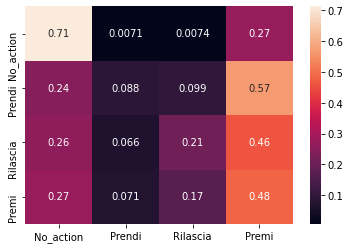

In [22]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list, y_pred_list, normalize='true')).rename(columns=idx2class, index=idx2class)
sns.heatmap(confusion_matrix_df, annot=True)
plt.savefig('Esperimento' + str(esperimento) + "_1.pdf", format='pdf')

In [23]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.75      0.71      0.73      6195
           1       0.39      0.09      0.14      2136
           2       0.36      0.21      0.27      1600
           3       0.20      0.48      0.29      1939

    accuracy                           0.49     11870
   macro avg       0.43      0.37      0.36     11870
weighted avg       0.54      0.49      0.49     11870



In [24]:
class2idx = {
    "No_action": 0,
    "Action": 1
}

idx2class = {v: k for k, v in class2idx.items()}

In [25]:
real2class = {
    0:0,
    1:1,
    2:1,
    3:1
}

In [26]:
y_pred_list = [(real2class[c]) for c in Y_p]
y_true_list = [(real2class[c]) for c in Y_t]

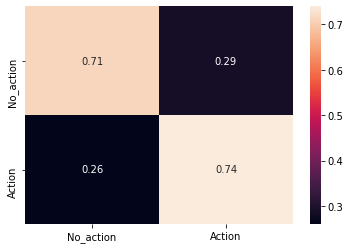

In [27]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list, y_pred_list, normalize='true')).rename(columns=idx2class, index=idx2class)
sns.heatmap(confusion_matrix_df, annot=True)
plt.savefig('Esperimento' + str(esperimento) + "_2.pdf", format='pdf')

In [28]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.75      0.71      0.73      6195
           1       0.70      0.74      0.72      5675

    accuracy                           0.73     11870
   macro avg       0.73      0.73      0.73     11870
weighted avg       0.73      0.73      0.73     11870



In [29]:
class2idx = {
    "No_action": 0,
    "P/R": 1,
    "Premi": 2
}

idx2class = {v: k for k, v in class2idx.items()}

In [30]:
real2class = {
    0:0,
    1:1,
    2:1,
    3:2
}

In [31]:
y_pred_list = [(real2class[c]) for c in Y_p]
y_true_list = [(real2class[c]) for c in Y_t]

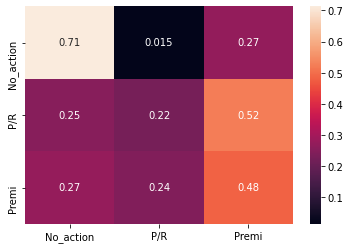

In [32]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list, y_pred_list, normalize='true')).rename(columns=idx2class, index=idx2class)
sns.heatmap(confusion_matrix_df, annot=True)
plt.savefig('Esperimento' + str(esperimento) + "_3.pdf", format='pdf')

In [33]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.75      0.71      0.73      6195
           1       0.60      0.22      0.33      3736
           2       0.20      0.48      0.29      1939

    accuracy                           0.52     11870
   macro avg       0.52      0.47      0.45     11870
weighted avg       0.61      0.52      0.53     11870



In [34]:
class2idx = {
    "No_action": 0,
    "P/P": 1,
    "Rilascia": 2
}

idx2class = {v: k for k, v in class2idx.items()}

In [35]:
real2class = {
    0:0,
    1:1,
    2:2,
    3:1
}

In [36]:
y_pred_list = [(real2class[c]) for c in Y_p]
y_true_list = [(real2class[c]) for c in Y_t]

<AxesSubplot:>

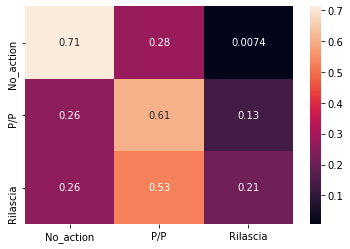

In [37]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list, y_pred_list, normalize='true')).rename(columns=idx2class, index=idx2class)
sns.heatmap(confusion_matrix_df, annot=True)

In [38]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.75      0.71      0.73      6195
           1       0.49      0.61      0.54      4075
           2       0.36      0.21      0.27      1600

    accuracy                           0.61     11870
   macro avg       0.53      0.51      0.51     11870
weighted avg       0.61      0.61      0.60     11870



In [39]:
class2idx = {
    "No_action": 0,
    "R/P": 1,
    "Prendi": 2
}

idx2class = {v: k for k, v in class2idx.items()}

In [40]:
real2class = {
    0:0,
    1:2,
    2:1,
    3:1
}

In [41]:
y_pred_list = [(real2class[c]) for c in Y_p]
y_true_list = [(real2class[c]) for c in Y_t]

<AxesSubplot:>

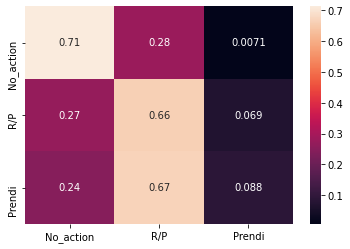

In [42]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list, y_pred_list, normalize='true')).rename(columns=idx2class, index=idx2class)
sns.heatmap(confusion_matrix_df, annot=True)

In [43]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.75      0.71      0.73      6195
           1       0.43      0.66      0.52      3539
           2       0.39      0.09      0.14      2136

    accuracy                           0.59     11870
   macro avg       0.52      0.49      0.46     11870
weighted avg       0.59      0.59      0.56     11870

